# Глубокое машинное обучение 

## HW1: Computer Vision

Дата *мягкого* дедлайна: `22.10.2025 23:59`

Дата **жесткого** дедлйна: `29.10.2025 23:59`

### **Правила сдачи (обязательно к прочтению)**
- После **жесткого** дедлайна работы не принимаются.
- После мягкого дедлайна каждый день снимается 10 баллов.
- Все похожие друг на друга работы оцениваются в 0.
- Если вы использовали какой-то публичный код, то это необходимо указать в комментарии и приложить ссылку на источник, иначе тоже может быть 0. :(
- За нечитаемый код, неэффективную реализацию и _некрасивые_ визуализации могут быть сняты баллы.
- Все вычисления должны быть воспроизводимые, поэтому не забывайте про `seed=42`, а также не забудьте перезапустить ноутбук и прожать все ячейки - ошибок быть не должно.
- Готовый ноутбук со всеми данными необходимо положить в архив. В архив необходимо полдожить ваш requirments.txt со всеми версиями библиотек.
- Архив называется следующим образом: `HW1_<your_latin_name>.zip`. Пример: `HW1_malkov.zip`
- Для всех трейнов важно предоставить графики лосов/эпох. Легче всего оставить ссылку на wandb, если такой возможности нет, то делайте графики сами.
- Использовать LLM можно, но допускается не более 50% сгенерированного кода в каждом задании. В случае использования LLM нужно комментарием указать модель, промт и источник инференса. Если нет комментария или количество сгенерированного кода больше 50%, то за задание ставится 0. Пример:
```python
# LLM START
"""
Model: Qwen3-30B-A3B-FP8 (указать квантизацию и кастомные параметры (top-p, top-p, temperature, ...), если есть)
Source: vLLM (здесь может быть API (openrouter.ai), может быть сайт с чатиком (chat.z.ai), может быть тула для локального инференса (lm-studio), может быть TG-бот (@jadvebot))
Prompt: Мой китайский друг, представь, что ты Ян Ле Кун, придумай за меня алгоритм детекции тачулечек
"""
print("Hello world")
# LLM END
```


### **Правила оценки работы**
Всего за работу можно получить 50 баллов. Вся домашняя работа делится на Advanced (для сильных) и Regular _(для нормальных)_, каждый из разделов дает по 25 баллов. Только выполнив Advanced задачи, можно получить **отл**. Чтобы получить **хор** (5), достаточно полностью выполнить все Regular задания.
Вот как выглядит отображение баллов в оценки:
| [От и До) | Оценка |
|-----------|--------|
| 0-5       | 1      |
| 5-10      | 2      |
| 10-15     | 3      |
| 15-20     | 4      |
| 20-26     | 5      |
| 26-30     | 6      |
| 30-35     | 7      |
| 35-40     | 8      |
| 40-45     | 9      |
| 45-50     | 10     |

### Предисловие
Вы уже узнали столько, чтобы попробовать себя в роли настоящего инженера или даже ресерчера. Сегодня мы с нуля пройдем весь путь создания детектора. Наша задача будет заключаться в том, чтобы подготовить модель для детекции медицинских масок на изображении.\

![FaceMask](https://user-images.githubusercontent.com/49322948/159162461-4552eee3-27db-49b2-ab6c-718106adc3c7.jpg)

### 0. Импорт всего, что нужно, и определение всех констант

In [178]:
import cv2
import random
import numpy as np
from bs4 import BeautifulSoup
import os   

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

import albumentations as A
from albumentations.pytorch import ToTensorV2

from torchvision.models.detection import ssdlite320_mobilenet_v3_large
from torchvision.models.detection.ssdlite import SSDLiteClassificationHead, SSDLiteRegressionHead

BATCH_SIZE = 8
IMG_SIZE = 320
SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

### (reg, 4.0) 1. Разметка

Здесь нет ссылки на датасет, потому что в реальной жизни данные вам, скорее всего, никто не даст. Вам нужно самим найти все необходимые данные и преобразовать их к нужному виду.

Готовую разметку необходимо подготовить в формате __Pascal VOC__. 

__Ваш датасет нужно запаковать в архив и отправить вместе с работой!__

In [179]:
# LINK FOR DATASET SOURCE
# https://www.kaggle.com/datasets/andrewmvd/face-mask-detection/data


DATASET_PATH = "./data/"
IMAGES_PATH = DATASET_PATH + "images/"
ANNOTATIONS_PATH = DATASET_PATH + "annotations/"

def generate_box(obj):
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 3
    return 2

### 2. Подготовка датасета
О, ну вот и задание на код. Всё просто, нужно подготовить `dataset` и `loader`, которые будут использоваться для трейна и теста.

#### (reg, 1.0) 2.1 Определение датасета.


In [180]:
class MyVOCDataset(Dataset):
    def __init__(self, images_path, annotations_path, transforms=None):
        self.images_path = images_path
        self.annotations_path = annotations_path
        self.transforms = transforms
        
        self.img_filenames = []
        for filename in os.listdir(images_path):
            xml_filename = os.path.splitext(filename)[0] + '.xml'
            xml_path = os.path.join(annotations_path, xml_filename)
            if os.path.exists(xml_path): 
                self.img_filenames.append(filename)
            else:
                print(f"no annotation for {filename}")


    def __len__(self):
        return len(self.img_filenames)

    def __getitem__(self, idx):
        img_filename = self.img_filenames[idx]
        img_path = os.path.join(self.images_path, img_filename)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        xml_filename = os.path.splitext(img_filename)[0] + '.xml'
        xml_path = os.path.join(self.annotations_path, xml_filename)

        with open(xml_path) as f:
            data = f.read()
            soup = BeautifulSoup(data, 'xml')
            objects = soup.find_all('object')

        boxes = [] 
        labels = [] 

        for obj in objects:
            boxes.append(generate_box(obj))
            labels.append(generate_label(obj))

        if self.transforms is not None:
            transformed = self.transforms(
                image=img,
                bboxes=boxes, 
                labels=labels
            )
            img = transformed['image'] 
            boxes = transformed['bboxes'] 
            labels = transformed['labels'] 
    

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels
        }

        return img, target

#### (reg, 1.0) 2.2 Подготовка аугументации
Аугументацию необходимо делать с помощью `albumentations`.

In [181]:
train_transforms = A.Compose([
    # A.Resize(height=IMG_SIZE, width=IMG_SIZE),  
    A.HorizontalFlip(p=0.5), 
    A.RandomBrightnessContrast(p=0.2),
    # A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),   
    # ToTensorV2(), 
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'], clip=True)) 

# test_transforms = A.Compose([
#     A.Resize(height=IMG_SIZE, width=IMG_SIZE), 
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
#     ToTensorV2(), 
# ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'], clip=True)) 

#### 2.3 Cобираем всё вместе

In [182]:
# def collate_fn(batch):
#     images, targets = zip(*batch)
#     return list(images), list(targets)

def collate_fn(batch):
    images = []
    targets = []
    for img, target in batch:
        img_tensor = torch.from_numpy(img).permute(2, 0, 1).float() 
        images.append(img_tensor)
        
        targets.append({
            "boxes": torch.tensor(target["boxes"], dtype=torch.float32),
            "labels": torch.tensor(target["labels"], dtype=torch.int64)
        })
    return images, targets

temp_dataset = MyVOCDataset(IMAGES_PATH, ANNOTATIONS_PATH, transforms=None)
total_size = len(temp_dataset)
train_size = int(0.8 * total_size)
test_size = max(1, total_size - train_size)

full_train_dataset = MyVOCDataset(IMAGES_PATH, ANNOTATIONS_PATH, transforms=train_transforms)
full_test_dataset = MyVOCDataset(IMAGES_PATH, ANNOTATIONS_PATH, transforms=None)

generator = torch.Generator().manual_seed(SEED)
train_indices, test_indices = random_split(range(total_size), [train_size, test_size], generator=generator)

train_dataset = torch.utils.data.Subset(full_train_dataset, train_indices)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

test_dataset = torch.utils.data.Subset(full_test_dataset, test_indices)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

#### (reg, 0.5) 2.4 Визулизация датасета
Визуализируйте пару примеров, чтобы убедиться, что вы нигде не ошиблись в разметке.

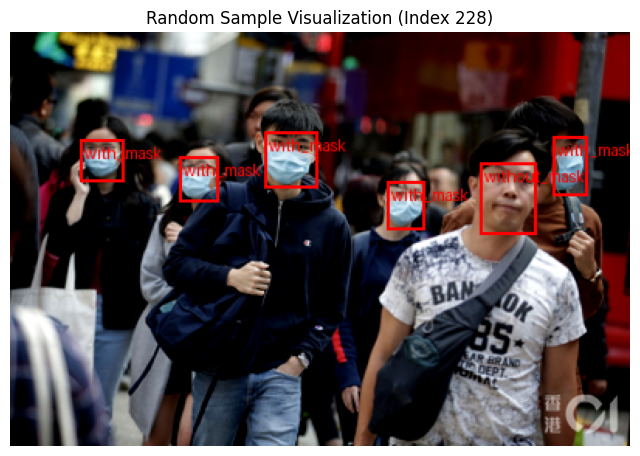

In [188]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes

idx = random.randint(0, len(train_dataset) - 1)
img, target = train_dataset[idx]

# Денормализация LLM: Qwen3-Max
# mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
# std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
# img_denorm = (img * std + mean).clamp(0, 1)
# img_uint8 = (img_denorm * 255).to(torch.uint8)
img_uint8 = torch.from_numpy(img).permute(2, 0, 1)

# без альбументации


class_names = ["background", "with_mask", "without_mask", "mask_incorrect"]
labels_list = [class_names[i] for i in target['labels']]

img_with_boxes = draw_bounding_boxes(
    image=img_uint8, 
    boxes=target['boxes'], 
    labels=labels_list,
    colors='red',
    width=2
)

plt.figure(figsize=(8, 8))
img_np = img_with_boxes.permute(1, 2, 0).numpy()
plt.imshow(img_np)
plt.title(f"Random Sample Visualization (Index {idx})")
plt.axis('off')
plt.show()

### 3. Обучение претрейн модели
Очень вам завидую, ведь это ваш первый настоящий трейн!

В прошлом курсе вы уже обучали бустинги и, может даже, с какими-нибудь сложными `hyperopt` или `gridsearch`, но поверьте — это совсем не то. В этом задании вам пригодится абсолютно всё, что мы к этому времени прошли, + мощности colab/kaggle/... + много времени и терпения. А всё почему? А всё потому, что мы будем с вами реализовывать **SSD** с нуля без каких-либо претрейнов и без VGG в бэкбоне (это всё-таки пережиток прошлого). Ну и сравним, что у нас получится с реализацией из `torchvision`, если всё сойдется.

#### 3.0 Теоретическая вводная.

Мы уже обсуждали на лекции, что такое SSD, и если кратко, то это One-Stage детектор, аналогичный YOLO, в котором есть несколько трюков:
1. Берут готовый бэкбон (VGG16), а не обучают его с нуля на ImageNet.
2. Вместо FC слоев используют только свертки. (прям как в RPN Faster-RCNN)
3. Из оригинальной VGG убирают все полносвязные слои и добавляют дополнительно 5 слоев сверток.
4. Вместо одного последнего слоя/активации (как в YOLO) берут 6 слоев из разных мест сети и «делают на них предсказания». Нужно это для того, чтобы лучше работать с объектами маленьких размеров, с которыми YOLO работает плохо.

Если более простыми словами объяснять проблематику из пункта 4, то в случае YOLO мы после всех преобразований оригинального изображения 448х448(x3) мы получаем карту активации 7x7(x1024). Таким образом, для каждого 64x64 квадрата оригинального изображения мы имеем всего 1x1x1024 фичи, характеризующий каждый из квадратов 64x64, при этом пространственной информации о содержании этих квадратов там почти нет. Зато пространственной информации будет больше на более ранних картах активации, например, размера 32х32, где каждый «элемент сетки» уже будет отвечать за квадрат 14x14 оригинального изображения. При этом, очевидно, «фичи» из карты активации 32х32 будут «слабее» фичей из 7х7, просто потому что слой 7х7 глубже. 

![SSD](https://www.acetrace.app/images/illustrations/ssd.png)

Если всё ещё не очень понятно, что в этом вашем SSD происходит, то обязательно посмотрите вот на этот реп: [клик](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection).

#### 3.1 Практическая вводная
Первое, что вам нужно сделать, — это прочитать [статью](https://arxiv.org/pdf/1512.02325) с вниманием ко всем деталям. Оттуда, например, нужно заимствовать формулки для расчета скейла: $s_k = s_{min} + \frac{s_{max}-s_{min}}{m-1}(k-1)$ и узнать про _hard negative mining_ (все нюансы из статьи правда важны, её же не глупые люди писали!).

Какие-то детали с точки зрения имплементации можно подчерпнуть из:
- [официальной имплементации](https://github.com/weiliu89/caffe/blob/2c4e4c2899ad7c3a997afef2c1fbac76adca1bad/examples/ssd/ssd_coco.py).
- [популярной учебной имплементации](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/model.py).
- [имплементации команды torch](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/ssd.py).
- [просто чья-то имплементация](https://github.com/amdegroot/ssd.pytorch/tree/master).

Также очень рекомендую прочитать блог команды torch относительно имплементации SSD и SSD-Lite (это SSD с MobileNet в бэкбоне):
- [SSD](https://pytorch.org/blog/torchvision-ssd-implementation/).
- [SSD-Lite](https://pytorch-hub-preview.netlify.app/blog/torchvision-ssdlite-implementation/).

#### **3.2 План действий (обязательно к прочтению)**
Теперь по поводу плана. Если вы не GPU-rich и не имеете доступа к серверу хотя бы с 4 GPU, то у вас вряд ли получится сделать претрейн SSD с нуля, чтобы она прям была пригодна для использования, поэтому мы с вами сфокусируемся на самой архитектуре и на непосредственно процессе обучения. Пункт с обучением своей модели будет выполнен, если:
1. Всё в вашей имплементации будет по делу.
2. Ваша имплементация будет спокойно **переобучаться** на одном батче за 1000 итераций. Это значит, что вы все правильно имплементировали.
3. У вас будет хотя бы **10-20 эпох**, где видно, что лосс классификации и лосс регрессии уверенно сходятся. При этом вам нужно показать минимум **пять** конфигураций обучения (с разными гиперпараметрами/лосами/оптимизациями/архитектурными триками). 

Если вы все сделали всё правильно, то на ваших графиках loss-а вы увидите что-то такое:
<div>
<img src="https://d3e0luujhwn38u.cloudfront.net/resized/kz9vKVmfahkZKS5UC_tJ8SJVHjeHIGDO8X-wiz8PzU8/s:3200/plain/s3://typefully-user-uploads/img/original/36777/1e59208e-44c4-4ed1-9c13-ee0010afc4cb.png" width="500"/>
</div>

Теперь пару советов с точки зрения самой реализации:
1. Бэкбон предлагаю брать максимально компактный типа MobileNetV3.
2. Предлагаю не брать какой-то большой датасет типа [COCO](https://public.roboflow.com/object-detection/microsoft-coco-subset/2), а ограничится [PASCAL VOC](https://public.roboflow.com/object-detection/pascal-voc-2012/1).
3. Здорово, если вы в какой-то имплементации увидите, что авторы используют SGD, а в другой использует какие трики с масштабированием дисперсии, но будьте уверены, в вашем случае это может не работать или работать не очень хорошо. Нужно все проверять самостоятельно.  

Куда обязательно нужно посмотреть: 
1. Уменьшения изображения — это ок для нашего домашнего претрейна.
2. Инициализация весов — это очень важно.
3. Сильный дисбаланс классов надо в любом случае компенсировать.

И несколько практических советов:
1. Обязательно делайте чекпоинты во время трейна.
2. Старайтесь сделать код максимально гибким и удобным для ваших экспериментов, а не копипастить одну и ту же функцию трейна с разными оптимизаторами.
3. Внимательно смотрите не только на значения лосов по эпохам, но по всем итерациям/степам — это сэкономит вам время.
4. Обязательно логируйте все эксперименты в тексте/тензорборде/wandb и смотрите графики. Не забывайте делать оценку на val-выборке, особенно если используете не очень большой датасет типа PASCAL.

#### (adv, 5.0) 3.3 Определение модели
VGG, скорее всего, очень сильно отличается по архитектуре от выбранного вами бэкбона, поэтому вам самостоятельно нужно подобрать слои, из которых брать фичи, а также определить количество анкеров и базовые соотношения сторон боксов.

Для того чтобы долго не высчитывать, какой размер сверток вам нужен на каждом этапе, лучше просто посмотреть, какие шейпы получаются на каждом слое. Вот пример кода:
```python
backbone = torchvision.models.get_model("mobilenet_v3_large", weights="DEFAULT").features
x = torch.randn(1, 3, IMAGE_SIZE, IMAGE_SIZE)
for i, layer in enumerate(backbone):
    x = layer(x)
    print('back', i, x.shape)

extra_layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(960, 256, 1, bias=False), nn.BatchNorm2d(256), nn.ReLU6(inplace=True),
                SeparableConv2d(256, 512, kernel_size=3, stride=2, padding=1)
            ),
            nn.Sequential(
                nn.Conv2d(512, 128, 1, bias=False), nn.BatchNorm2d(128), nn.ReLU6(inplace=True),
                SeparableConv2d(128, 256, kernel_size=3, stride=2, padding=1)
            ),
        ])

for i, layer in enumerate(extra_layers):
    x = layer(x)
    print('ext', i, x.shape)
```

In [105]:
class MySSD(nn.Module):
    def __init__(self, *args):
        super().__init__()
        # YOUR CODE HERE 

    def _generate_default_boxes(self, *args, s_min=0.1, s_max=0.9):
        """
        Функция генерации дефолтных боксов, как из статьи
        """
        # YOUR CODE HERE
        return

    def forward(self, x):
        # YOUR CODE HERE
        return

#### (adv, 2.0) 3.4 Определение лоса
В оригинальной статье лосс состоит из двух компонет: лосс регрессии (L1_smooth) и лосс классификации (кросс-энтропия) с трюком Hard negative mining.

In [106]:
class MySSDLoss(nn.Module):
    def __init__(self, *args):
        super().__init__()
        # YOUR CODE HERE
        
    def forward(self, *args):
        # YOUR CODE HERE
        return conf_loss + self.alpha * loc_loss, conf_loss, loc_loss

#### (adv, 1.0) 3.5 Аугументация для претрейна

In [107]:
# YOUR CODE HERE
pre_train_transforms = A.Compose([])
pre_val_transforms = A.Compose([])

#### (adv, 1.0) 3.6 Подготовка датасета и лоудера для претрейна
> Нужно обязательно переисользовать `MyVOCDataset`.

In [108]:
# YOUR CODE HERE

# pre_train_dataset =
# pre_train_loader = 

# pre_val_dataset =
# pre_val_loader =

# pre_test_dataset =
# pre_test_loader =

#### (reg, 2.0) 3.7 Визулизация датасета
Визуализируйте пару примеров, чтобы убедиться, что вы нигде не ошиблись в разметке.

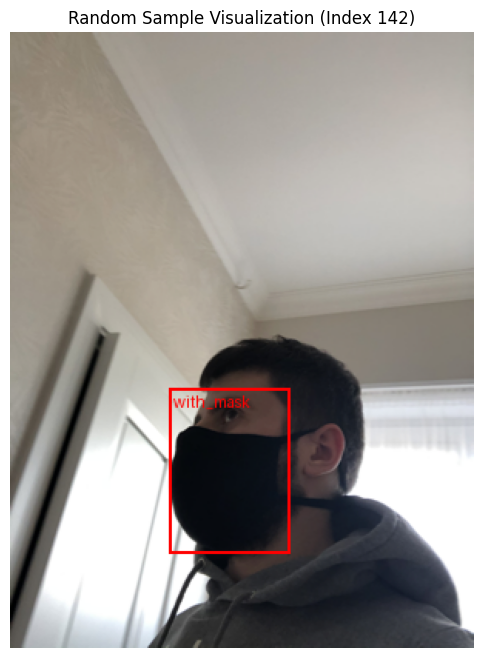

In [189]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes

idx = random.randint(0, len(train_dataset) - 1)
img, target = train_dataset[idx]

# Денормализация
# mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
# std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
# img_denorm = (img * std + mean).clamp(0, 1)
# img_uint8 = (img_denorm * 255).to(torch.uint8)
img_uint8 = torch.from_numpy(img).permute(2, 0, 1)

class_names = ["background", "with_mask", "without_mask", "mask_incorrect"]
labels_list = [class_names[i] for i in target['labels']]

img_with_boxes = draw_bounding_boxes(
    image=img_uint8, 
    boxes=target['boxes'], 
    labels=labels_list,
    colors='red',
    width=2
)

plt.figure(figsize=(8, 8))
img_np = img_with_boxes.permute(1, 2, 0).numpy()
plt.imshow(img_np)
plt.title(f"Random Sample Visualization (Index {idx})")
plt.axis('off')
plt.show()

#### (adv, 1.0) 3.8 Подготовка train-loop для переобученя на одном батче
> Не забывайте про перевод модели в режим трнйна (`model.train()`) или в режим инференса (`model.eval()`), а также помните про контекстный менджер: (`torch.no_grad()`).

In [110]:
def run_single_batch_overfit(*args, iterations=1500):
    # YOUR CODE HERE
    pass

#### (adv, 2.0) 3.9 Оверфит на одном батче

In [111]:
# YOUR CODE HERE

#### (adv, 1.0) 3.10 Визуализация экспериментов

In [112]:
# YOUR CODE HERE OR LINK TO WANDB OR ANY VISUALIZAION

#### (adv, 1.0) 3.11 Подготовка train-loop для обучения претрейна


In [113]:
def run_training_stage(*args,):
    # YOUR CODE HERE
    pass

#### (adv, 8.0) 3.12 Обучение претрейна
> Не нужно ждать, что все сойдется, достаточно просто показать 5 разных конфигураций обучения с 20-30 эпохами, где лосс _уверенно_ падает.

In [114]:
# YOUR CODE HERE

#### (adv, 1.0) 3.13 Визуализация экспериментов

In [115]:
# YOUR CODE HERE OR LINK TO WANDB OR ANY VISUALIZAION

Если вы дошли до этого пункта, то вы просто герой! („• ֊ •„)੭

По секрету: если на собеседовании вы скажете, что вы _Senior AI Developer_, то никто даже не поймет подвоха.

### 4. Обучение основной модели на базе готового претрейна
В этом блоке мы зафайнтюним предобученную SSD-Lite на нашей собственной разметке.

#### (reg, 1.0) 4.1 Импортируйте веса модели
Вот сразу ссылка на сурсы, если что: [клик](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/ssdlite.py). Для вас задача ещё сложнее: дефолтно в [SSD](https://github.com/pytorch/vision/blob/7a13ad0f89167089616b51f4fd07f978cf1f17e4/torchvision/models/detection/ssd.py#L453) и [SSD-Lite](https://github.com/pytorch/vision/blob/7a13ad0f89167089616b51f4fd07f978cf1f17e4/torchvision/models/detection/ssdlite.py#L310) включен NMS, а нам надо его выключить, потому что мы сделаем его сами. Напомнию, что NMS на этапе обучения __[не нужен](https://github.com/pytorch/vision/blob/7a13ad0f89167089616b51f4fd07f978cf1f17e4/torchvision/models/detection/ssd.py#L404)__. (вам нужно не только отключить NMS в торчовой реализации , но и декодирование на этапе инференса. вам нужно переопределить форвард, но, как я и сказал, отключить декодирование (вместо готовых боксов возвращать то что мы непосредственно предсказываем + анкеры) только на этапе инференса, то есть только для случая когда self.training == False)

In [190]:
from torchvision.models.detection.ssdlite import SSDLiteHead

class ModifiedSSD(nn.Module):
    def __init__(self, num_classes=4): 
        super().__init__()

        self.model = ssdlite320_mobilenet_v3_large(weights="DEFAULT")

        # --- ИЗМЕНЕНИЕ КОЛИЧЕСТВА КЛАССОВ --- LLM Qwen3-Max

        original_head = self.model.head 
        original_cls_convs = original_head.classification_head.module_list 
        original_reg_convs = original_head.regression_head.module_list       

        in_channels = [conv[1].in_channels for conv in original_cls_convs] 
        num_anchors = [conv[1].out_channels // 4 for conv in original_reg_convs] 

        norm_layer = nn.BatchNorm2d

        new_head = SSDLiteHead(
            in_channels=in_channels,   
            num_anchors=num_anchors,    
            num_classes=num_classes,    
            norm_layer=norm_layer       
        )

        self.model.head = new_head

        # end LLM


    def forward(self, images, targets=None):
        if self.model.training:
            return self.model(images, targets)


        original_image_sizes = [img.shape[-2:] for img in images]
        images, targets = self.model.transform(images, targets)
        features_dict = self.model.backbone(images.tensors)
        features = list(features_dict.values())
        head_outputs = self.model.head(features)
        anchors = self.model.anchor_generator(images, features)

        return {
            "cls_logits": head_outputs["cls_logits"], 
            "bbox_regression": head_outputs["bbox_regression"],
            "anchors": anchors,
            "image_sizes": images.image_sizes,
            "original_image_sizes": original_image_sizes,
        }

model = ModifiedSSD(num_classes=4) # 0: background, 1: with_mask, 2: without_mask, 3: mask_incorrect
model.to(DEVICE) 

ModifiedSSD(
  (model): SSD(
    (backbone): SSDLiteFeatureExtractorMobileNet(
      (features): Sequential(
        (0): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            (2): Hardswish()
          )
          (1): InvertedResidual(
            (block): Sequential(
              (0): Conv2dNormActivation(
                (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
                (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
                (2): ReLU(inplace=True)
              )
              (1): Conv2dNormActivation(
                (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=T

#### (reg, 4.0) 4.1 Подготовьте train-loop

In [191]:
def train_ssd(model, train_loader, optimizer, num_epochs, device):
    model.to(device)
    model.train()

    for epoch in range(1, num_epochs + 1):
        running_loss = 0.0
        for images, targets in train_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            loss = sum(loss_dict.values())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch}: train loss = {avg_loss:.4f}")



#### (reg, 3.0) 4.2 Обучите модель на нашем датасете

In [196]:
for p in model.parameters():
    p.requires_grad = False

for p in model.model.head.parameters(): 
    p.requires_grad = True

for p in model.model.backbone.features[-2:].parameters():
    p.requires_grad = True

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=1e-4, momentum=0.9, weight_decay=1e-4)

train_ssd(model, train_loader, optimizer, num_epochs=15, device=DEVICE)

/tmp/ipykernel_123803/3079529269.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "boxes": torch.tensor(target["boxes"], dtype=torch.float32),
/tmp/ipykernel_123803/3079529269.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels": torch.tensor(target["labels"], dtype=torch.int64)


Epoch 1: train loss = 2.1368
Epoch 2: train loss = 2.0981
Epoch 3: train loss = 2.1474
Epoch 4: train loss = 2.1456
Epoch 5: train loss = 2.0909
Epoch 6: train loss = 2.0860
Epoch 7: train loss = 2.0317
Epoch 8: train loss = 2.0664
Epoch 9: train loss = 2.1099
Epoch 10: train loss = 2.1254
Epoch 11: train loss = 2.0518
Epoch 12: train loss = 2.0186
Epoch 13: train loss = 2.0711
Epoch 14: train loss = 2.0552
Epoch 15: train loss = 2.0504


#### (reg, 2.0) 4.3 Визуализация эксперимента

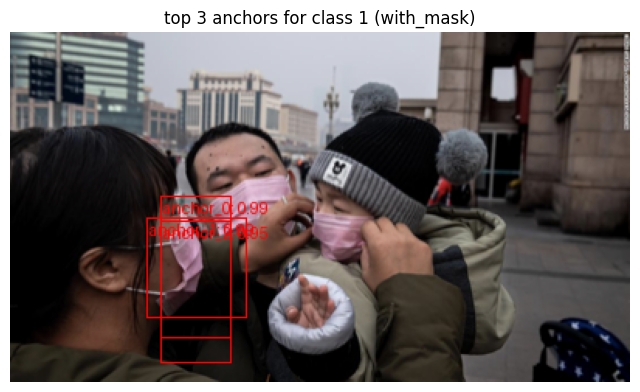

In [206]:
import random
import torch
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes

idx = random.randint(0, len(test_dataset) - 1)
img, target = test_dataset[idx] 

# mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
# std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
# img_denorm = (img * std + mean).clamp(0, 1)
# img_uint8 = (img_denorm * 255).to(torch.uint8)
img_uint8 = torch.from_numpy(img).permute(2, 0, 1)
img = torch.from_numpy(img).permute(2, 0, 1).float()

model.eval()
with torch.no_grad():
    outputs = model([img.to(DEVICE)])

cls_logits = outputs["cls_logits"].squeeze(0) 
anchors = outputs["anchors"][0]                
scores = torch.softmax(cls_logits, dim=-1) 
anchor_scores = scores[:, 1]  
top_scores, top_indices = torch.topk(anchor_scores, k=min(3, len(anchor_scores)))

top_anchors = anchors[top_indices].cpu()
labels_str = [f"anchor_{i}: {s:.2f}" for i, s in enumerate(top_scores.cpu().tolist())]

img_with_anchors = draw_bounding_boxes(
    image=img_uint8,
    boxes=top_anchors,
    labels=labels_str,
    colors="red",
    width=1,
    font_size=10
)

plt.figure(figsize=(8, 8))
plt.imshow(img_with_anchors.permute(1, 2, 0).numpy())
plt.title(f"top {3} anchors for class 1 (with_mask)")
plt.axis("off")
plt.show()

#### (reg, 2.0) 4.4 Реализация NMS
Мы уже обсуждали алгоритм NMS на лекции, но если забылось, то вот отличная [статья](https://deepmachinelearning.ru/docs/Neural-networks/Object-detection/Non-maximum-supression).

In [207]:
def area(boxes):
    return (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

def calculate_iou(boxes1, boxes2):
    left_top = torch.max(boxes1[:, None, :2], boxes2[:, :2]) # (x_top, y_top)
    right_bottom = torch.min(boxes1[:, None, 2:], boxes2[:, 2:]) # (x_bottom, y_bottom)
    width_height = (right_bottom - left_top).clamp(min=0) # (width, height) 
    inter = width_height[:, :, 0] * width_height[:, :, 1]
    union = area(boxes1)[:, None] + area(boxes2) - inter
    return inter / union.clamp(min=1e-9)

def nms(boxes, scores, iou_threshold):
    if boxes.numel() == 0:
        return torch.empty((0,), dtype=torch.long, device=boxes.device)

    sorted_indices = torch.argsort(scores, descending=True)
    keep = []

    while sorted_indices.numel() > 0:
        current_idx = sorted_indices[0]
        keep.append(current_idx)

        if sorted_indices.numel() == 1:
            break

        current_box = boxes[current_idx:current_idx+1]  
        remaining_boxes = boxes[sorted_indices[1:]] 
        ious = calculate_iou(current_box, remaining_boxes).squeeze(0)
        sorted_indices = sorted_indices[1:][ious < iou_threshold] 

    return torch.tensor(keep, dtype=torch.long, device=boxes.device)

#### (reg, 2.0) 4.5 Реализация функции декодирования предсказаний
Нужно реализовать функцию для переовода offset + default_box/anchors, которые выдает модель, в xyxy bbox.

In [213]:
import math

def decode_boxes(bbox_deltas, anchors, scale_xy=10.0, scale_wh=5.0, bbox_xform_clip=math.log(1000. / 16)):
    anchors = anchors.to(bbox_deltas.dtype)

    widths = anchors[:, 2] - anchors[:, 0] 
    heights = anchors[:, 3] - anchors[:, 1]
    ctr_x = anchors[:, 0] + 0.5 * widths   
    ctr_y = anchors[:, 1] + 0.5 * heights 

    dx = bbox_deltas[:, 0]
    dy = bbox_deltas[:, 1]
    dw = bbox_deltas[:, 2]
    dh = bbox_deltas[:, 3]

    dx = dx / scale_xy
    dy = dy / scale_xy
    dw = dw / scale_wh
    dh = dh / scale_wh

    dw = torch.clamp(dw, min=-bbox_xform_clip, max=bbox_xform_clip)
    dh = torch.clamp(dh, min=-bbox_xform_clip, max=bbox_xform_clip)

    pred_ctr_x = dx * widths + ctr_x
    pred_ctr_y = dy * heights + ctr_y
    pred_w = torch.exp(dw) * widths
    pred_h = torch.exp(dh) * heights

    half_w = 0.5 * pred_w
    half_h = 0.5 * pred_h

    x1 = pred_ctr_x - half_w
    y1 = pred_ctr_y - half_h
    x2 = pred_ctr_x + half_w
    y2 = pred_ctr_y + half_h

    return torch.stack([x1, y1, x2, y2], dim=1)

#### (reg, 0.5) 4.5 Визуализация работы модели на val датасете
Выведит пару примеров детекции масок

Pred boxes shape: torch.Size([3234, 4])
Pred boxes sample (first 5): tensor([[  6.2264,   4.1714,  32.2548,  22.9212],
        [-27.4034, -23.0659,  50.4007,  36.8039],
        [ -7.2315,   1.0614,  26.4200,  19.6820],
        [  9.8413,   7.7723,  35.9417,  31.6022],
        [ 28.5061,   0.1389,  55.4302,  15.3792]], device='cuda:0')
Expected image bounds: (0, 0, 400, 225)
Pred boxes min/max x: -189.51490783691406 553.9130249023438
Pred boxes min/max y: -90.4010009765625 299.0877685546875
Boxes with x1<0: 251, y1<0: 291, x2>W: 280, y2>H: 331


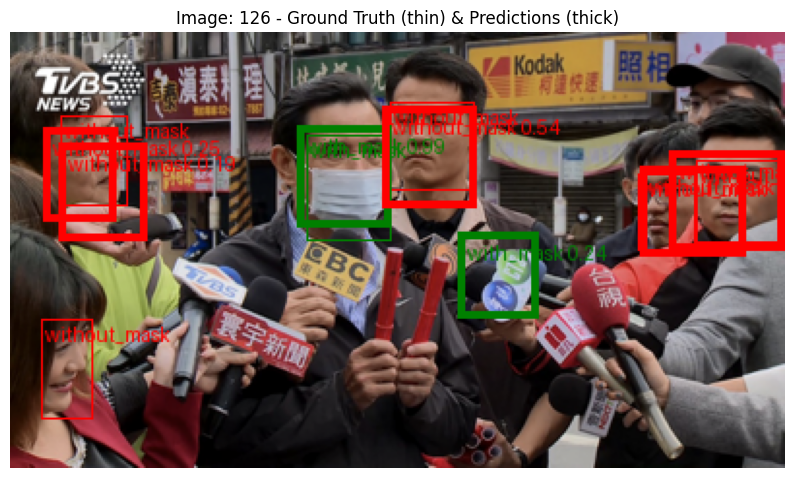

Pred boxes shape: torch.Size([3234, 4])
Pred boxes sample (first 5): tensor([[  4.6442,   2.9218,  30.5934,  22.9880],
        [-34.4871, -21.8751,  43.5957,  38.0810],
        [ -8.1644,  -1.4572,  22.7171,  17.0823],
        [  5.9309,   2.3193,  30.1589,  26.2977],
        [ 22.3973,   1.7516,  50.9265,  16.6715]], device='cuda:0')
Expected image bounds: (0, 0, 400, 226)
Pred boxes min/max x: -196.33319091796875 550.2030029296875
Pred boxes min/max y: -87.58556365966797 305.1103210449219
Boxes with x1<0: 237, y1<0: 235, x2>W: 274, y2>H: 333


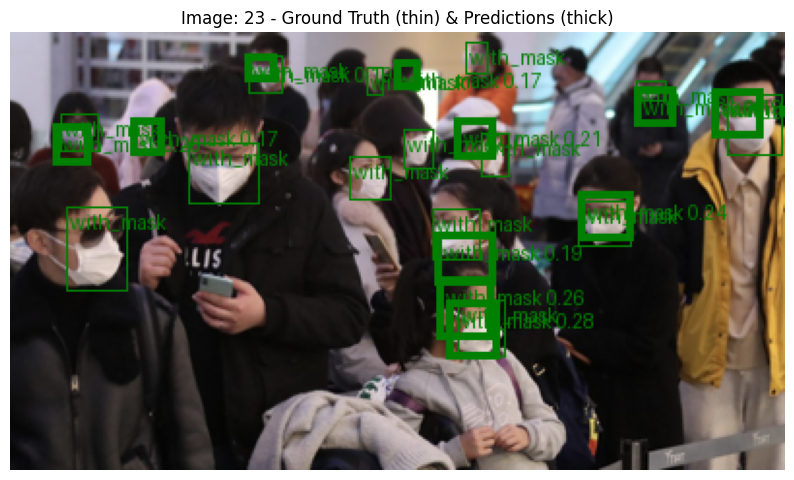

Pred boxes shape: torch.Size([3234, 4])
Pred boxes sample (first 5): tensor([[ -2.8348,  -4.2712,  25.6017,  35.1952],
        [-21.5886, -36.7812,  35.3914,  62.9318],
        [-13.4951,  -7.7853,  16.4029,  31.8896],
        [  1.7981, -15.7961,  26.0328,  34.4483],
        [  7.6146,  -1.2829,  38.5549,  31.9064]], device='cuda:0')
Expected image bounds: (0, 0, 301, 400)
Pred boxes min/max x: -162.25392150878906 418.5777282714844
Pred boxes min/max y: -169.0304718017578 542.8970947265625
Boxes with x1<0: 334, y1<0: 338, x2>W: 336, y2>H: 354


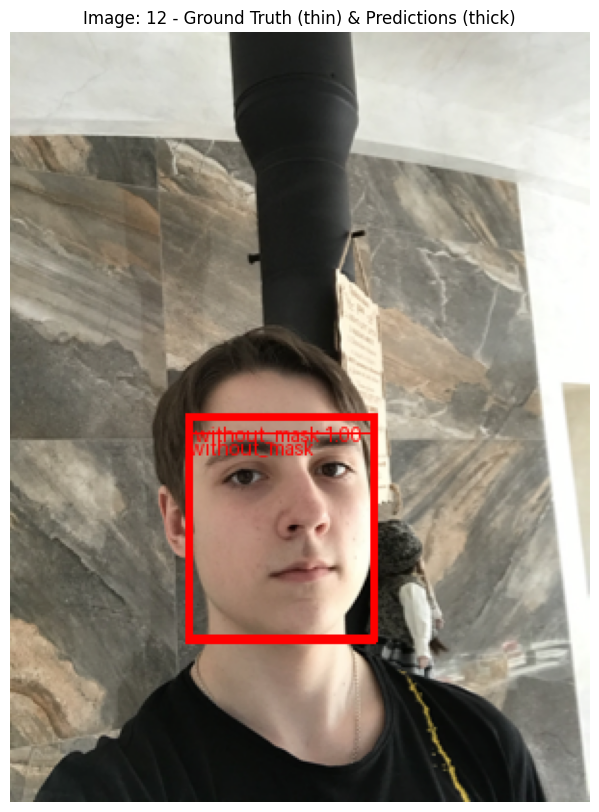

In [245]:
def visualize_predictions(model, dataset, num_samples=3, score_threshold=0.3, iou_threshold=0.5):
    model.eval() 
    indices = random.sample(range(len(dataset)), num_samples)

    class_colors = {
        1: "green",  
        2: "red",  
        3: "orange"
    }

    class_names = {
        1: "with_mask",
        2: "without_mask",
        3: "mask_weared_incorrect"
    }

    for idx in indices:
        img_tensor, target = dataset[idx]

        # Денормализация 
        # mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        # std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        # img_denorm = (img_tensor * std + mean).clamp(0, 1)
        # img_uint8 = (img_denorm * 255).to(torch.uint8)

        img_uint8 = torch.from_numpy(img_tensor).permute(2, 0, 1)
        img_tensor = torch.from_numpy(img_tensor).permute(2, 0, 1).float()

        with torch.no_grad():
            outputs = model([img_tensor.to(DEVICE)])


        cls_logits = outputs["cls_logits"].squeeze(0)
        bbox_regression = outputs["bbox_regression"].squeeze(0)
        anchors = outputs["anchors"][0]
        pred_boxes = decode_boxes(bbox_regression, anchors) 
        scores = torch.softmax(cls_logits, dim=-1)


        #масштабирование
        orig_h, orig_w = outputs["original_image_sizes"][0]  
        padded_h, padded_w = outputs["image_sizes"][0]      
        pred_boxes[:, [0, 2]] *= orig_w / padded_w
        pred_boxes[:, [1, 3]] *= orig_h / padded_h


        print("Pred boxes shape:", pred_boxes.shape)
        if pred_boxes.numel() > 0:
            print("Pred boxes sample (first 5):", pred_boxes[:5])
            H, W = img_tensor.shape[-2:] # 320, 320
            print(f"Expected image bounds: (0, 0, {W}, {H})")
            print("Pred boxes min/max x:", pred_boxes[:, [0, 2]].min().item(), pred_boxes[:, [0, 2]].max().item())
            print("Pred boxes min/max y:", pred_boxes[:, [1, 3]].min().item(), pred_boxes[:, [1, 3]].max().item())
            # Проверим, сколько боксов выходит за пределы
            invalid_x1 = (pred_boxes[:, 0] < 0).sum()
            invalid_y1 = (pred_boxes[:, 1] < 0).sum()
            invalid_x2 = (pred_boxes[:, 2] > W).sum()
            invalid_y2 = (pred_boxes[:, 3] > H).sum()
            print(f"Boxes with x1<0: {invalid_x1}, y1<0: {invalid_y1}, x2>W: {invalid_x2}, y2>H: {invalid_y2}")

        # убираем фон
        object_scores = scores[:, 1:]
        max_scores, class_ids_offset = torch.max(object_scores, dim=1) 
        class_ids = class_ids_offset + 1  # обратно в 1, 2, 3 вместо 0,1,2

        # фильтрация
        keep = max_scores >= score_threshold
        filtered_boxes = pred_boxes[keep]
        filtered_scores = max_scores[keep]
        filtered_class_ids = class_ids[keep]


        keep_nms = []
        for cls_id in [1, 2, 3]:
            cls_mask = filtered_class_ids == cls_id
            if not cls_mask.any():
                continue
            cls_boxes = filtered_boxes[cls_mask]
            cls_scores = filtered_scores[cls_mask]
            nms_indices = nms(cls_boxes, cls_scores, iou_threshold)
            keep_nms.append(torch.nonzero(cls_mask, as_tuple=True)[0][nms_indices])

        if keep_nms:
            keep_nms = torch.cat(keep_nms, dim=0)
            final_boxes = filtered_boxes[keep_nms]
            final_class_ids = filtered_class_ids[keep_nms]
            final_scores = filtered_scores[keep_nms]
        else:
            final_boxes = torch.empty((0, 4), device=pred_boxes.device)
            final_class_ids = torch.empty((0,), dtype=torch.long, device=filtered_class_ids.device)
            final_scores = torch.empty((0,), device=filtered_scores.device)

        # визуализация 
        gt_labels_str = [class_names[int(l)] for l in target['labels']]
        pred_labels_str = [f"{class_names[int(l)]} {s:.2f}" for l, s in zip(final_class_ids.cpu(), final_scores.cpu())]
        gt_colors = [class_colors[int(l)] for l in target['labels']]
        pred_colors = [class_colors[int(l)] for l in final_class_ids.cpu()]

        img_with_gt = draw_bounding_boxes(
            image=img_uint8,
            boxes=target['boxes'],
            labels=gt_labels_str,
            colors=gt_colors,
            width=1,
            font_size=12
        )

        if final_boxes.numel() > 0:
            img_with_both = draw_bounding_boxes(
                image=img_with_gt,
                boxes=final_boxes.cpu().int(),  
                labels=pred_labels_str,
                colors=pred_colors,
                width=4,
                font_size=10
            )
        else:
            img_with_both = img_with_gt 

        plt.figure(figsize=(10, 10))
        plt.imshow(img_with_both.permute(1, 2, 0).numpy())
        plt.title(f"Image: {idx} - Ground Truth (thin) & Predictions (thick)")
        plt.axis("off")
        plt.show()

visualize_predictions(model, test_dataset, num_samples=3, score_threshold=0.17, iou_threshold=0.5)

#### (reg, 2.0) 4.6 Подсчет IoU
Для того чтобы оценить качество работы самой детекции чаще всего измеряют IoU. Пропустите вашу модель чере NMS и посчитайте IoU отонсительно Ground Truth. Вычисление IoU нужно реализовать самостоятелньо!

In [ ]:
def area(boxes):
    return (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

def calculate_iou(boxes1, boxes2):
    left_top = torch.max(boxes1[:, None, :2], boxes2[:, :2]) # (x_top, y_top)
    right_bottom = torch.min(boxes1[:, None, 2:], boxes2[:, 2:]) # (x_bottom, y_bottom)
    width_height = (right_bottom - left_top).clamp(min=0) # (width, height) 
    inter = width_height[:, :, 0] * width_height[:, :, 1]
    union = area(boxes1)[:, None] + area(boxes2) - inter
    return inter / union.clamp(min=1e-9)

#### (reg, 2.0) 4.7 Подсчет mAP
Про `Mean Average Precision` вы точно слышали из прошлого курса. Считается немного модифицированный `PR AUC` по всем наблюдениям одного класса (у нас он только один, фон не считается) и получаем `AP`, а дальше усредняем `AP` по всем классам и получаем `mAP`. [Тут](https://learnopencv.com/mean-average-precision-map-object-detection-model-evaluation-metric/) пример на пальцах. Расчет mAP тоже нужно реализовать самостоятельно.

In [ ]:

def calculate_ap(recalls, precisions):
    if len(recalls) == 0:
        return 0.0

    recalls = np.concatenate(([0.], recalls, [1.]))
    precisions = np.concatenate(([0.], precisions, [0.]))
    for i in range(len(precisions) - 2, -1, -1):
        precisions[i] = max(precisions[i], precisions[i + 1])

    i = np.where(recalls[1:] != recalls[:-1])[0]
    ap = np.sum((recalls[i + 1] - recalls[i]) * precisions[i + 1])
    return ap

def evaluate_map(model, test_loader, device, iou_threshold=0.5):
    model.eval()
    detections = {cls_id: [] for cls_id in [1, 2, 3]}  
    total_gt = {cls_id: 0 for cls_id in [1, 2, 3]}

    with torch.no_grad():
        for images, targets in test_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for i in range(len(images)):
                anchors = outputs["anchors"][i]
                bbox_reg = outputs["bbox_regression"][i]
                cls_logit = outputs["cls_logits"][i]

                pred_boxes = decode_boxes(bbox_reg, anchors, scale_xy=10.0, scale_wh=5.0)
                orig_h, orig_w = outputs["original_image_sizes"][i]
                padded_h, padded_w = outputs["image_sizes"][i]
                pred_boxes[:, [0, 2]] *= orig_w / padded_w
                pred_boxes[:, [1, 3]] *= orig_h / padded_h

                scores = torch.softmax(cls_logit, dim=-1)
                obj_scores = scores[:, 1:]  
                max_scores, class_offsets = obj_scores.max(dim=1)
                class_ids = class_offsets + 1  
                gt_boxes = targets[i]["boxes"].to(device)
                gt_labels = targets[i]["labels"]
                for cls_id in [1, 2, 3]:
                    total_gt[cls_id] += (gt_labels == cls_id).sum().item()

                for cls_id in [1, 2, 3]:
                    mask = (class_ids == cls_id)
                    if not mask.any():
                        continue
                    cls_pred_boxes = pred_boxes[mask]
                    cls_scores = max_scores[mask]

                    sorted_scores, sort_idx = torch.sort(cls_scores, descending=True)
                    sorted_boxes = cls_pred_boxes[sort_idx]
                    gt_mask = (gt_labels == cls_id)
                    cls_gt_boxes = gt_boxes[gt_mask]
                    gt_matched = torch.zeros(len(cls_gt_boxes), dtype=torch.bool, device=device)

                    for j in range(len(sorted_boxes)):
                        pred_box = sorted_boxes[j].unsqueeze(0) 
                        if len(cls_gt_boxes) == 0:
                            is_tp = False
                        else:
                            ious = calculate_iou(pred_box, cls_gt_boxes).squeeze(0)  
                            max_iou, max_idx = ious.max(dim=0)

                            if max_iou >= iou_threshold and not gt_matched[max_idx]:
                                is_tp = True
                                gt_matched[max_idx] = True
                            else:
                                is_tp = False

                        detections[cls_id].append((sorted_scores[j].item(), is_tp))


    aps = {}
    for cls_id in [1, 2, 3]:
        if not detections[cls_id]:
            aps[cls_id] = 0.0
            continue
        detections[cls_id].sort(key=lambda x: x[0], reverse=True)
        scores, tps = zip(*detections[cls_id])
        tps = np.array(tps, dtype=np.float32)
        fps = 1 - tps
        cum_tp = np.cumsum(tps)
        cum_fp = np.cumsum(fps)
        precisions = cum_tp / (cum_tp + cum_fp + 1e-8)
        recalls = cum_tp / (total_gt[cls_id] + 1e-8)
        aps[cls_id] = calculate_ap(recalls, precisions)

    mAP = np.mean(list(aps.values()))
    return mAP, aps


mAP, aps = evaluate_map(model, test_loader, DEVICE, iou_threshold=0.5)
print(f"mAP@[IoU=0.5] = {mAP:.4f}")
print(f"AP per class: {aps}")

/tmp/ipykernel_123803/3079529269.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "boxes": torch.tensor(target["boxes"], dtype=torch.float32),
/tmp/ipykernel_123803/3079529269.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels": torch.tensor(target["labels"], dtype=torch.int64)


mAP@[IoU=0.5] = 0.1005
AP per class: {1: np.float64(0.13844907569508688), 2: np.float64(0.07285003692250559), 3: np.float64(0.09023866452942751)}


### 5. Обучение модели на базе собственного претрейна
**Все пункты дальше необязательные! И их можно делать, только если у вас хоть чуть-чуть сошелся лосс и модель классифицирует объекты лучше рандома!**

#### 5.1 Дообучение вашего претрейна 

In [125]:
# YOUR CODE HERE

#### 5.2 Визуализация эксперимента

In [126]:
# YOUR CODE HERE

#### 5.3 Подсчет IoU

In [127]:
# YOUR CODE HERE

#### 5.3 Подсчет mAP

In [128]:
# YOUR CODE HERE